In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
#Lag features in refer to a technique where you use past values of a variable as features for predicting future values.
df= pd.read_csv('/content/PJME_hourly.csv')
df= df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


<Axes: title={'center': 'PJME Hourly Consumption'}, xlabel='Datetime'>

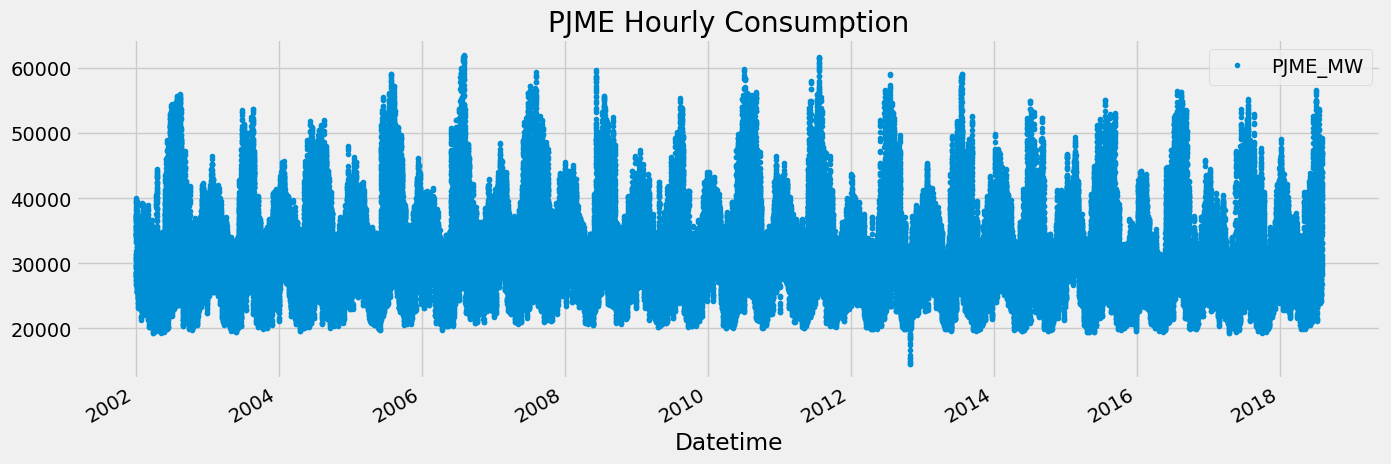

In [ ]:
df.plot(style='.', figsize=(15,5),color=color_pal[0], title='PJME Hourly Consumption')

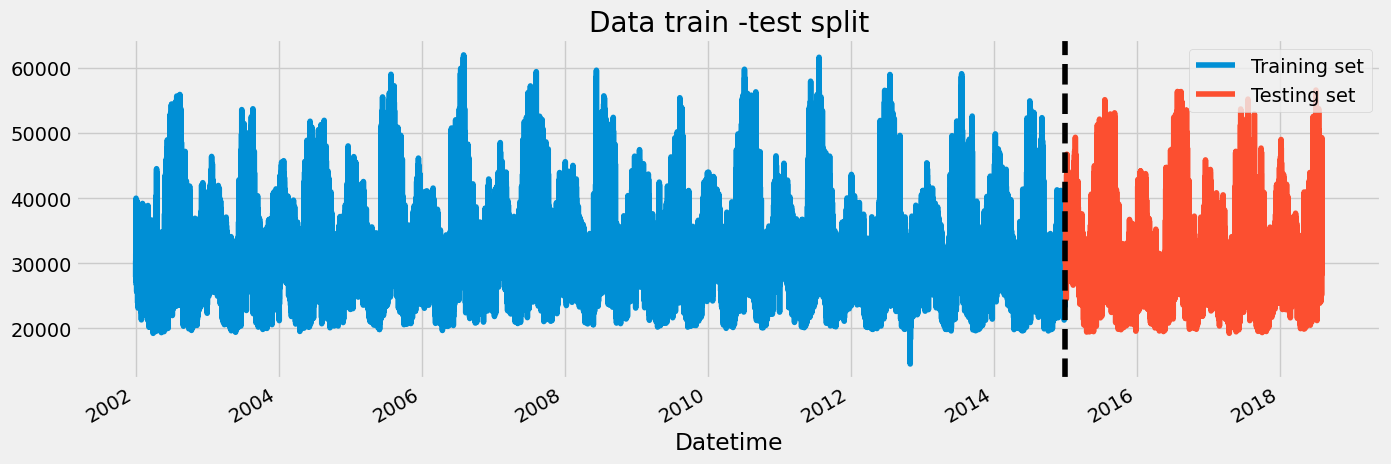

In [ ]:
train=df.loc[df.index < '01-01-2015']
test=df.loc[df.index >= '01-01-2015']
fig, ax =plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training set',title='Data train -test split')
test.plot(ax=ax, label='Testing set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training set','Testing set'])
plt.show()

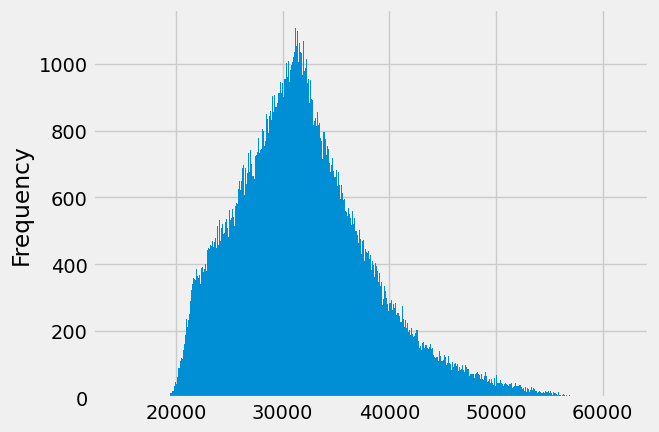

In [ ]:
#OUTLIER ANALYSIS & REMOVAL
df['PJME_MW'].plot(kind='hist', bins=500)
plt.show()

<Axes: xlabel='Datetime'>

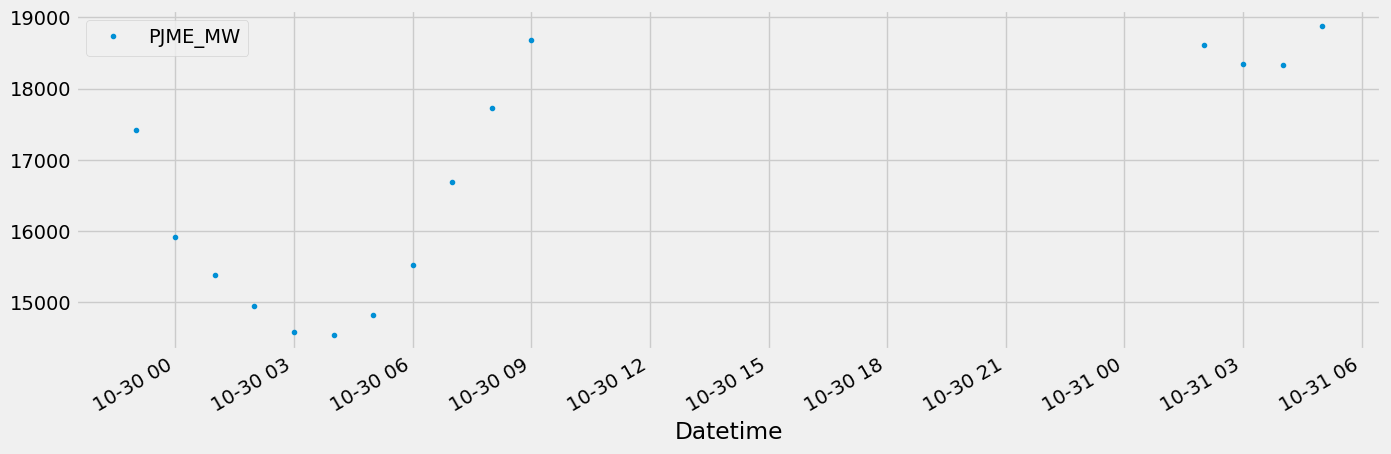

In [ ]:
#Now to check for extreme outliers
df.query('PJME_MW < 19_000').plot(style='.',figsize=(15,5))

In [ ]:
df = df.query('PJME_MW < 19_000').copy()

In [ ]:
#Timeseries cross validation
#gap is the number of samples to exclude from the end of each train set before the test set
#to avoid overalp
#data must always sorted while using timeseriessplit

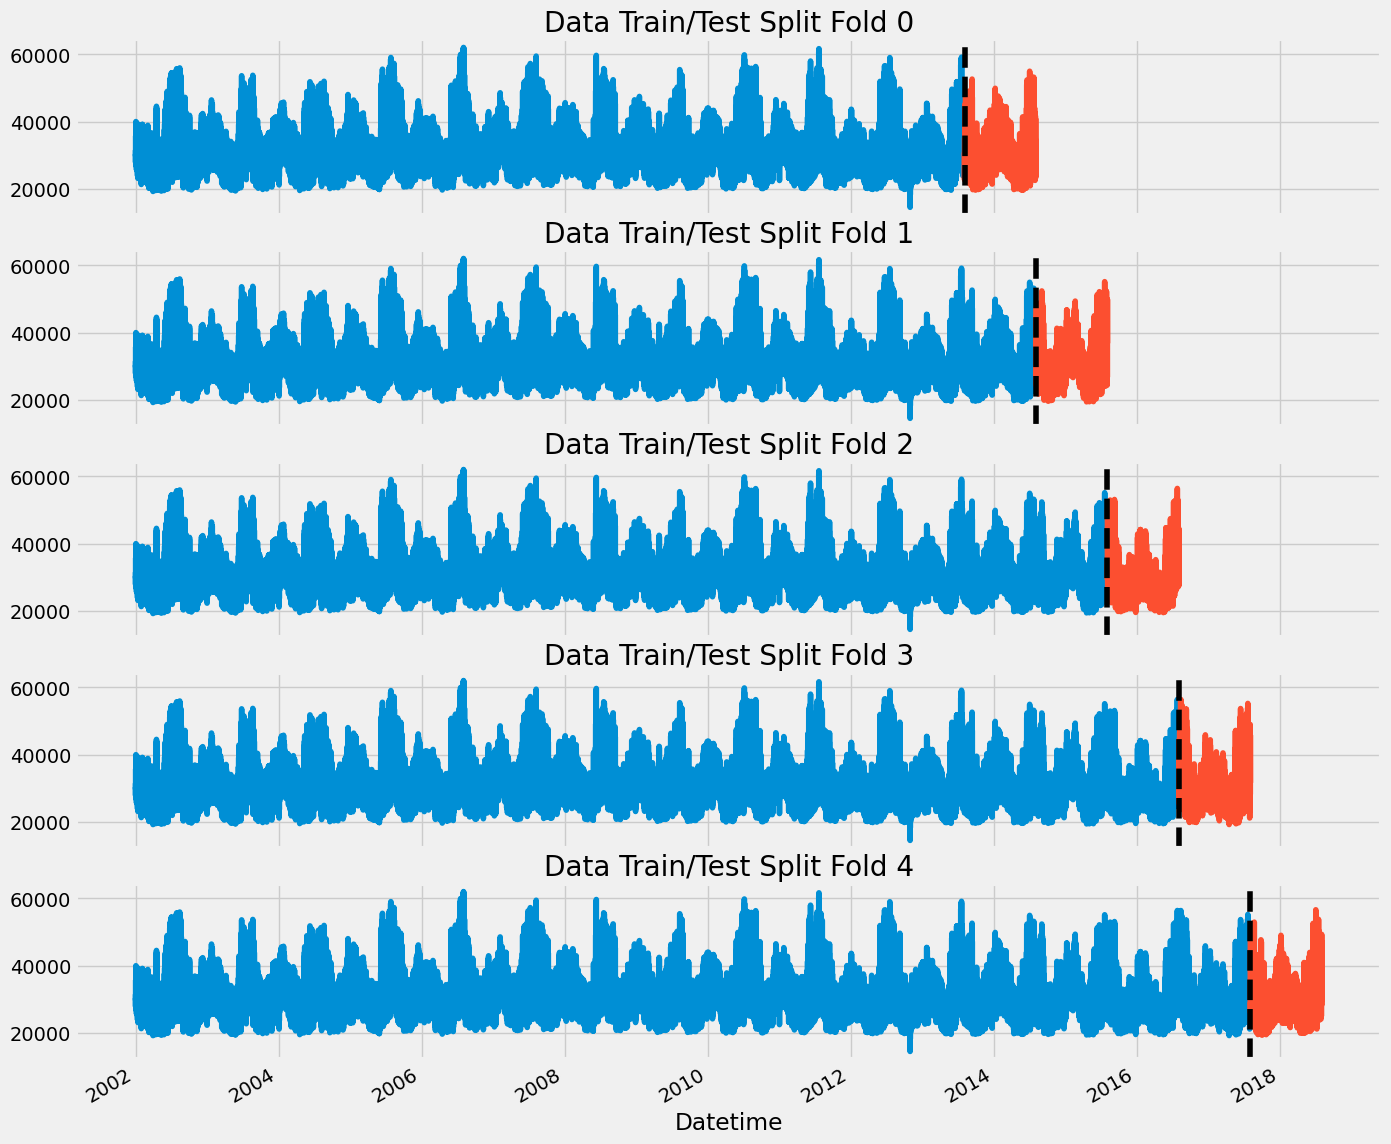

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5,test_size=24*365*1, gap =24)
df = df.sort_index()
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], #Plot on a single axis
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold], #Plot on a single axis
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--') #Use axs instead of axs[fold]
    fold += 1
plt.show()

In [ ]:
# Forecasting Horizon
# forecast horizon is the length of time into the future for which forecasts are to be prepared
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)


In [ ]:
#Lag Features
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = add_lags(df)

In [ ]:
#Train Using Cross Validation
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32730.70639	validation_1-rmse:31956.68992


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.55336	validation_1-rmse:11909.41611
[200]	validation_0-rmse:5747.09818	validation_1-rmse:5364.37773
[300]	validation_0-rmse:3873.51430	validation_1-rmse:3899.82339
[400]	validation_0-rmse:3436.83821	validation_1-rmse:3761.31682
[472]	validation_0-rmse:3339.96200	validation_1-rmse:3766.70959
[0]	validation_0-rmse:32670.52224	validation_1-rmse:32138.89280


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.49682	validation_1-rmse:12224.28419
[200]	validation_0-rmse:5757.00363	validation_1-rmse:5660.61027
[300]	validation_0-rmse:3906.64261	validation_1-rmse:3931.54029
[400]	validation_0-rmse:3480.55395	validation_1-rmse:3594.18390
[500]	validation_0-rmse:3356.18631	validation_1-rmse:3521.16813
[600]	validation_0-rmse:3300.89593	validation_1-rmse:3485.23578
[700]	validation_0-rmse:3261.72962	validation_1-rmse:3464.90388
[800]	validation_0-rmse:3225.50605	validation_1-rmse:3438.64983
[900]	validation_0-rmse:3197.54901	validation_1-rmse:3430.10289
[999]	validation_0-rmse:3171.60041	validation_1-rmse:3423.30152
[0]	validation_0-rmse:32629.68486	validation_1-rmse:31073.29137


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12498.98688	validation_1-rmse:11138.61827
[200]	validation_0-rmse:5752.02891	validation_1-rmse:4816.91952
[300]	validation_0-rmse:3919.15626	validation_1-rmse:3552.13740
[400]	validation_0-rmse:3498.18633	validation_1-rmse:3492.25509
[0]	validation_0-rmse:32527.02577	validation_1-rmse:31475.38351


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12461.96904	validation_1-rmse:12019.48183
[200]	validation_0-rmse:5737.89539	validation_1-rmse:5797.75367
[300]	validation_0-rmse:3915.62082	validation_1-rmse:4384.68884
[400]	validation_0-rmse:3498.63291	validation_1-rmse:4170.01062
[500]	validation_0-rmse:3382.11681	validation_1-rmse:4115.69724
[600]	validation_0-rmse:3323.84410	validation_1-rmse:4103.91546
[700]	validation_0-rmse:3281.57869	validation_1-rmse:4089.38230
[800]	validation_0-rmse:3250.66728	validation_1-rmse:4083.77098
[900]	validation_0-rmse:3223.32980	validation_1-rmse:4070.70740
[999]	validation_0-rmse:3198.63020	validation_1-rmse:4045.11440
[0]	validation_0-rmse:32460.74594	validation_1-rmse:31463.90740


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.48694	validation_1-rmse:11959.07454
[200]	validation_0-rmse:5752.20383	validation_1-rmse:5612.24486
[300]	validation_0-rmse:3950.03192	validation_1-rmse:4153.37990
[400]	validation_0-rmse:3541.82183	validation_1-rmse:4006.17705
[429]	validation_0-rmse:3496.00914	validation_1-rmse:4007.15210


In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3740.8982
Fold scores:[3758.5256000579657, 3423.147857410298, 3476.1877399654186, 4045.114401082416, 4001.5152064402228]


In [ ]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'
X_all = df[FEATURES]
y_all = df[TARGET]
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32402.66145


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.65722
[200]	validation_0-rmse:5753.26676
[300]	validation_0-rmse:3974.78237
[400]	validation_0-rmse:3574.03211
[499]	validation_0-rmse:3459.27580


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
#Predicting the future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

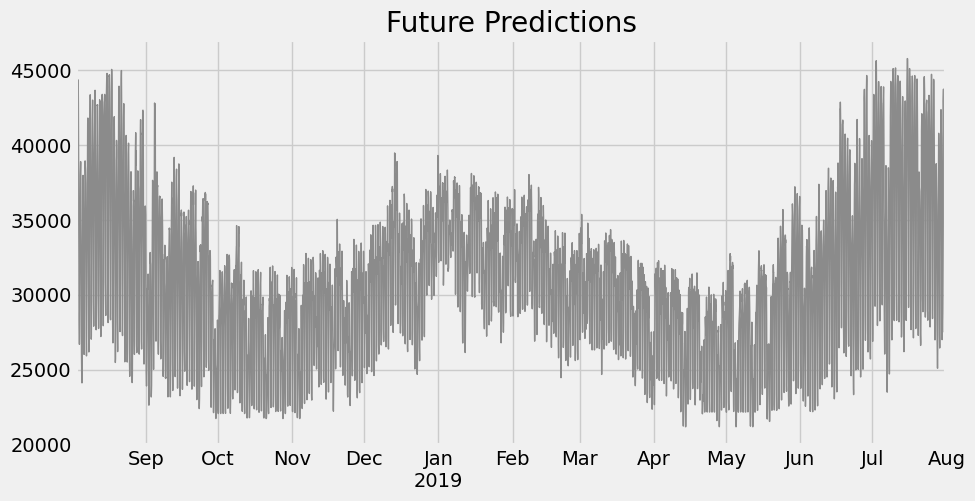

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()